<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/class_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. ladda data

In [6]:
import pandas as pd
import numpy as np

data=pd.read_csv('data_lektion.csv', sep=';')

In [8]:
data

,Infill,Orientation,Nozzle Diameter,Y1,Y2,Y3,Y4
0,5,0,0.2,8.0,9.2,14.2,10.6
1,5,0,1.0,26.2,33.6,40.0,28.8
2,5,90,0.2,14.8,15.2,16.0,15.2
3,5,90,1.0,44.0,44.0,45.0,43.8
4,100,0,0.2,16.6,12.4,12.8,14.0
5,100,0,1.0,28.2,24.4,24.4,23.2
6,100,90,0.2,14.8,15.0,14.6,20.8
7,100,90,1.0,42.2,43.2,41.8,41.0


In [22]:
data.loc[:,'Infill'].min()

5

In [23]:
# create dictionary for parameters
inputs_labels = {'A' : data.columns[0],
                 'B' :  data.columns[1],
                 'C' :  data.columns[2]}

#create list of data for high and low.
dat = [ ('A',data.loc[:,'Infill'].min(),data.loc[:,'Infill'].max()),
        ('B',data.loc[:,'Orientation'].min(),data.loc[:,'Orientation'].max()),
        ('C',data.loc[:,'Nozzle Diameter '].min(),data.loc[:,'Nozzle Diameter '].max())]

# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

#print dataframe
inputs_df

,low,high,label
index,,,
A,5.0,100.0,Infill
B,0.0,90.0,Orientation
C,0.2,1.0,Nozzle Diameter


,Infill,Orientation,Nozzle Diameter
0,5,0,0.2
1,5,0,1.0
2,5,90,0.2
3,5,90,1.0
4,100,0,0.2
5,100,0,1.0
6,100,90,0.2
7,100,90,1.0


In [24]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,high,label,encoded_low,encoded_high
index,,,,,
A,5.0,100.0,Infill,-1.0,1.0
B,0.0,90.0,Orientation,-1.0,1.0
C,0.2,1.0,Nozzle Diameter,-1.0,1.0


In [25]:
import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1],[-1,1]))
encoded_inputs

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1)]

In [26]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['A','B','C']
results

,A,B,C
0,-1,-1,-1
1,1,-1,-1
2,-1,1,-1
3,1,1,-1
4,-1,-1,1
5,1,-1,1
6,-1,1,1
7,1,1,1


In [27]:
real_experiment = results

var_labels = []
for var in ['A','B','C']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else inputs_df.loc[var]['high'] ,
        axis=1)

print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


,Infill,Orientation,Nozzle Diameter
0,5.0,0.0,0.2
1,100.0,0.0,0.2
2,5.0,90.0,0.2
3,100.0,90.0,0.2
4,5.0,0.0,1.0
5,100.0,0.0,1.0
6,5.0,90.0,1.0
7,100.0,90.0,1.0


2. Gör experiment

In [39]:
y=data.loc[:,'Y1':'Y4']
y_mean=y.mean(axis=1)

results['y']=y_mean
results

,A,B,C,Infill,Orientation,Nozzle Diameter,y
0,-1,-1,-1,5.0,0.0,0.2,10.50
1,1,-1,-1,100.0,0.0,0.2,32.15
2,-1,1,-1,5.0,90.0,0.2,15.30
3,1,1,-1,100.0,90.0,0.2,44.20
4,-1,-1,1,5.0,0.0,1.0,13.95
5,1,-1,1,100.0,0.0,1.0,25.05
6,-1,1,1,5.0,90.0,1.0,16.30
7,1,1,1,100.0,90.0,1.0,42.05


array([[<Axes: title={'center': 'Y1'}>, <Axes: title={'center': 'Y2'}>],
       [<Axes: title={'center': 'Y3'}>, <Axes: title={'center': 'Y4'}>]],
      dtype=object)

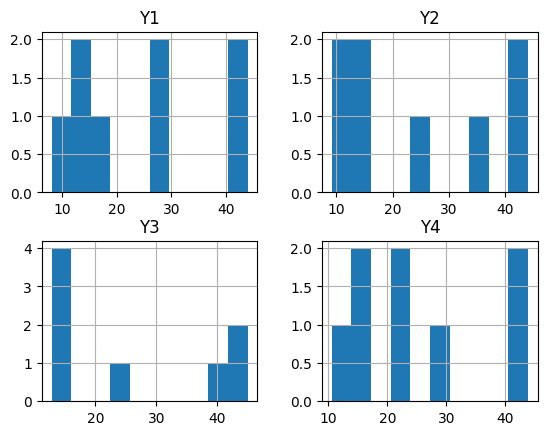

In [54]:
import statsmodels.formula.api as smf


dat=results.loc[:,'A':'C']
dat['y']=results.loc[:,'y']

mod = smf.ols(formula='y ~ A + B + C + A:B + A:C + B:C', data=dat)

res = mod.fit()
res.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     29.36
Date:                Thu, 21 Sep 2023   Prob (F-statistic):              0.140
Time:                        12:45:25   Log-Likelihood:                -10.728
No. Observations:                   8   AIC:                             35.46
Df Residuals:                       1   BIC:                             36.01
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.9375      0.925     26.959      0.024      13.184      36.691
A             10.9250      0.925     11.811      0.054      -0.828      22.678
B              4.5250      0.925      4.892      0.128      -7.228      16.278
C             -0.6000      0.925     -0.649      0.634     -12.353      11.153
A:B            2.7375      0.925      2.959      0.207      -9.016      14.491
A:C           -1.7125      0.925     -1.851      0.315     -13.466      10.041
B:C            0.3125      0.925      0.338      0.793     -11.441      12.066
==============================================================================
Omnibus:                        8.655   Durbin-Watson:                   2.500
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                1.333
Skew:                           0.000   Prob(JB):                        0.513
Kurtosis:                       1.000   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
params=pd.DataFrame(res.params)
params

,0
Intercept,24.9375
A,10.9250
B,4.5250
C,-0.6000
A:B,2.7375
A:C,-1.7125
B:C,0.3125


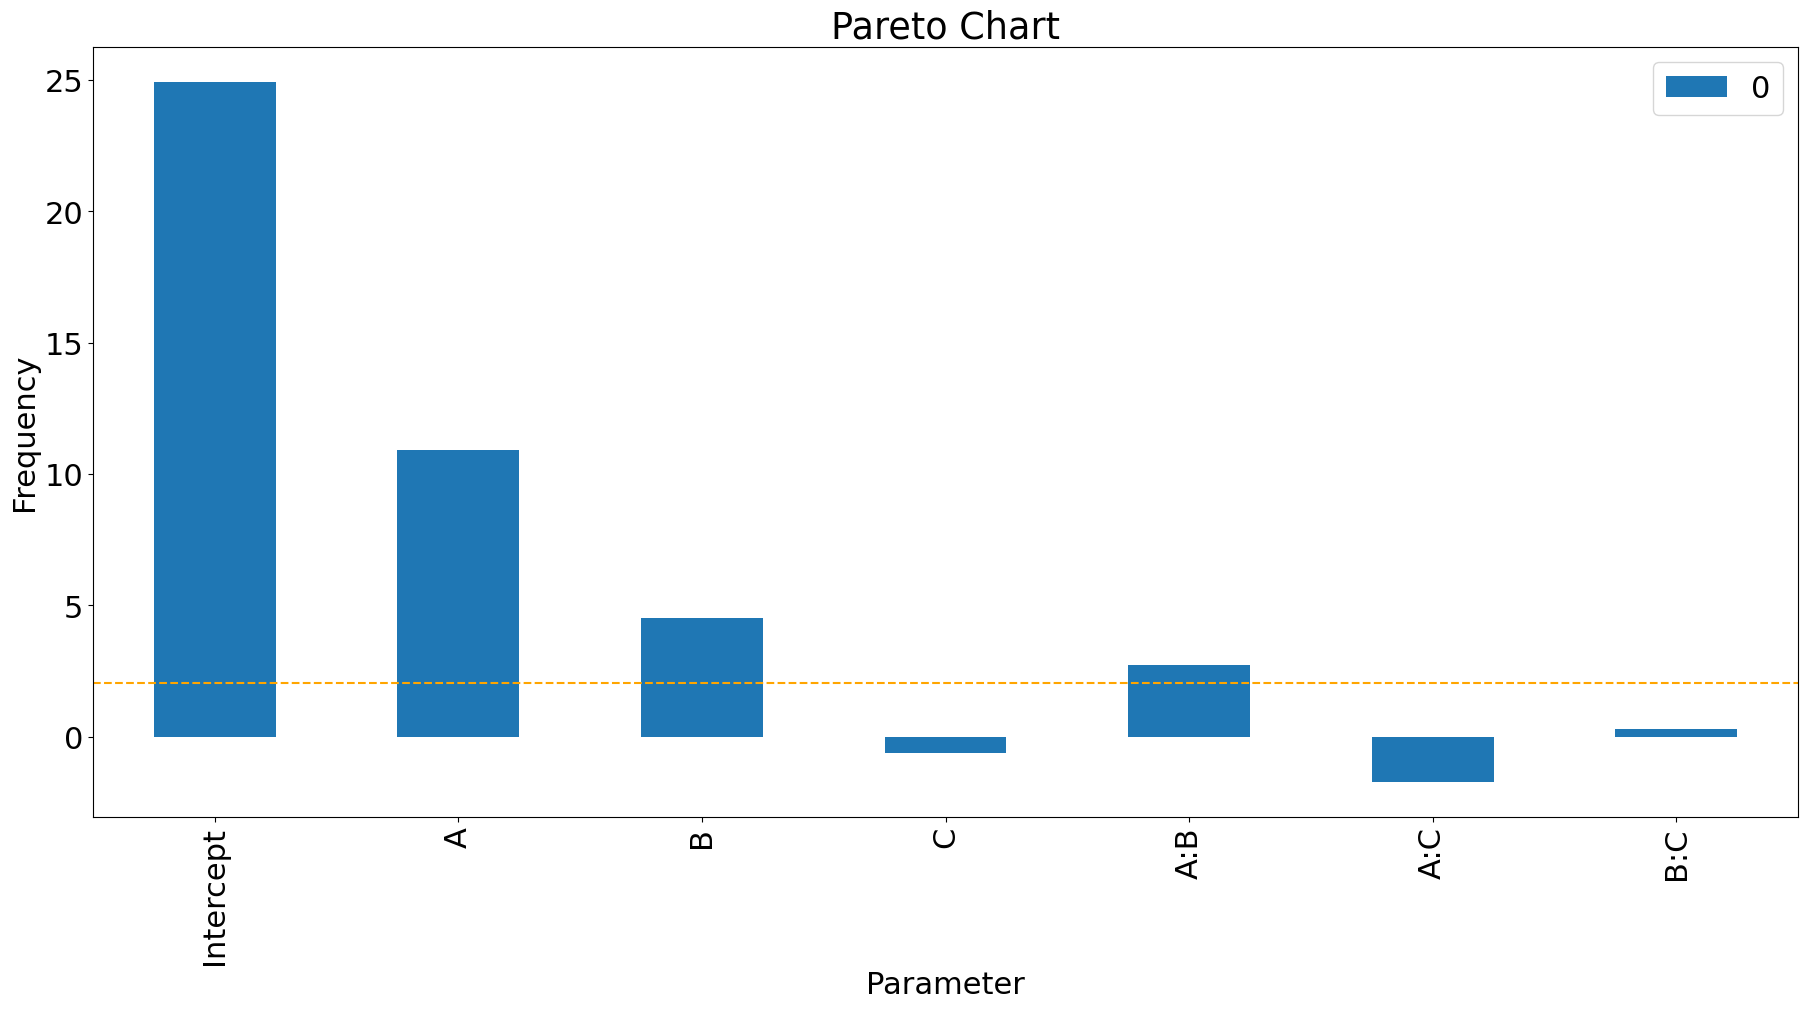

In [64]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({'font.size': 22})
# Set figure and axis
fig, ax = plt.subplots(figsize=(22,10))

# Plot bars (i.e. frequencies)
ax.set_title("Pareto Chart")
ax.set_xlabel("Parameter")
ax.set_ylabel("Frequency");
params.plot.bar(ax=ax)
ax.axhline(2.06, color="orange", linestyle="dashed")

# Second y axis (i.e. cumulative percentage)
#ax2 = ax.twinx()
#ax2.plot(effects_df.index, effects_df["cum_percentage"], color="red", marker="D", ms=7)
#params.plot(y="cum_percentage", color="red", marker="D", ms=7, ax=ax2)
#ax2.yaxis.set_major_formatter(PercentFormatter())
#ax2.set_ylabel("Cumulative Percentage");

In [65]:
mod = smf.ols(formula='y ~ A + B + A:B ', data=dat)

res = mod.fit()
res.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     46.26
Date:                Thu, 21 Sep 2023   Prob (F-statistic):            0.00146
Time:                        12:52:32   Log-Likelihood:                -17.135
No. Observations:                   8   AIC:                             42.27
Df Residuals:                       4   BIC:                             42.59
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.9375      1.030     24.204      0.000      22.077      27.798
A             10.9250      1.030     10.604      0.000       8.064      13.786
B              4.5250      1.030      4.392      0.012       1.664       7.386
A:B            2.7375      1.030      2.657      0.057      -0.123       5.598
==============================================================================
Omnibus:                        0.036   Durbin-Watson:                   2.763
Prob(Omnibus):                  0.982   Jarque-Bera (JB):                0.143
Skew:                           0.000   Prob(JB):                        0.931
Kurtosis:                       2.345   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""